Import Libraries

In [1]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Linear Regression models
from sklearn.linear_model import LinearRegression

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

Data preprocessing

Read data

In [2]:
df = pd.read_csv('Samsung_clean.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2010,16060,16180,16000,16180,11978.36523,11950800
1,1/5/2010,16520,16580,16300,16440,12170.84668,27925850
2,1/6/2010,16580,16820,16520,16820,12452.17090,22948850
3,1/7/2010,16820,16820,16260,16260,12037.59082,22107950
4,1/8/2010,16400,16420,16120,16420,12156.04102,14777550


Reset index

In [3]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the Close column as dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)
df_Close.head()


,Close
0,16180
1,16440
2,16820
3,16260
4,16420


Data normalization

In [4]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

Data splitting

In [5]:
# Split data into training, validation, and test sets (6:2:2)
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

Model training and testing

Training process

In [6]:
# Prepare training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

# Train Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R-squared:", model.score(x_train, y_train))

Intercept: -0.0036303185770690805
Coefficients: [0.00015942]
R-squared: 0.7619957667016589


Testing process

In [7]:
# Validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(x_val)

# Evaluate
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val_inv, y_pred_val_inv)

print(f"MAPE (Validation): {val_mape}")
print(f"RMSE (Validation): {val_rmse}")
print(f"MSLE (Validation): {val_msle}")


MAPE (Validation): 0.1837251214131133
RMSE (Validation): 17025.954624397873
MSLE (Validation): 0.06983590722292106


In [8]:
# Test data
x_test = np.array(range(train_size + val_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred_test = model.predict(x_test)

# Evaluate
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_test_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test_inv, y_pred_test_inv)

print(f"MAPE (Test): {test_mape}")
print(f"RMSE (Test): {test_rmse}")
print(f"MSLE (Test): {test_msle}")


MAPE (Test): 0.12895808447109436
RMSE (Test): 10687.784141518012
MSLE (Test): 0.024239967509698247


Predicting the next 30 days

In [9]:
# Create index for next 30 days
last_index = df_Close.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

Preparing the prediction data

Prediction process

In [10]:
# Predict next 30 days
y_next_30_days = model.predict(x_next_30_days)
y_next_30_days_inv = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))

print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_inv.flatten())


Predicted closing prices for the next 30 days:
[68128.94827497 68143.04125247 68157.13422997 68171.22720748
 68185.32018498 68199.41316248 68213.50613998 68227.59911748
 68241.69209499 68255.78507249 68269.87804999 68283.97102749
 68298.06400499 68312.15698249 68326.24996    68340.3429375
 68354.435915   68368.5288925  68382.62187    68396.71484751
 68410.80782501 68424.90080251 68438.99378001 68453.08675751
 68467.17973502 68481.27271252 68495.36569002 68509.45866752
 68523.55164502 68537.64462252]


Preparing the forecast date index

In [11]:
# Generate future date index
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

Visualization

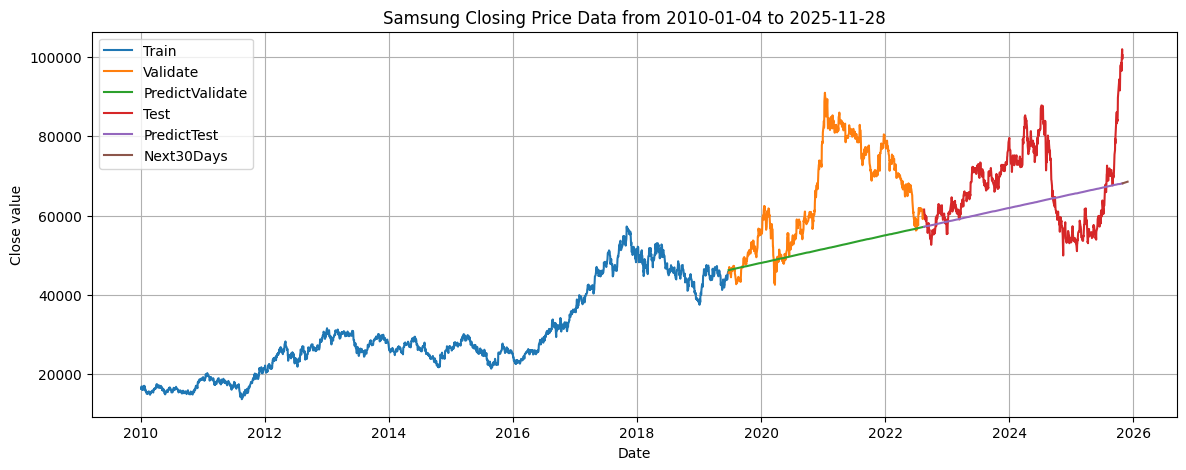

In [12]:
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(df.index[train_size:train_size + val_size], y_val_inv)
plt.plot(df.index[train_size:train_size + val_size], y_pred_val_inv)
plt.plot(df.index[train_size + val_size:], y_test_inv)
plt.plot(df.index[train_size + val_size:], y_pred_test_inv)
plt.plot(index_next_30_days, y_next_30_days_inv)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Days'])
plt.grid()
plt.title(f"Samsung Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('LR_622_Samsung.png')
plt.show()
